# Calibration

Part of a [Recidivism Case Study](https://github.com/AllenDowney/RecidivismCaseStudy)

by [Allen Downey](https://allendowney.com)

[MIT License](https://opensource.org/licenses/MIT)

## Review

In the previous notebook we replicated the analysis reported in
"[Machine Bias](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)", by Julia Angwin, Jeff Larson, Surya Mattu and Lauren Kirchner, and published by [ProPublica](https://www.propublica.org) in May 2016.

After the ProPublica article, the Washington Post published a response by Sam Corbett-Davies, Emma Pierson, Avi Feller and Sharad Goel: "[A computer program used for bail and sentencing decisions was labeled biased against blacks. It’s actually not that clear.](https://www.washingtonpost.com/news/monkey-cage/wp/2016/10/17/can-an-algorithm-be-racist-our-analysis-is-more-cautious-than-propublicas/)".

I strongly encourage you to read both of those articles before you go on.  In this notebook, I explain some of the arguments presented in the Washington Post (WaPo) article, and we will replicate their analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data

The authors of "Machine Bias" published their data and analysis in [this repository](https://github.com/propublica/compas-analysis).

The terms of use for the data [are here](https://www.propublica.org/datastore/terms).  In compliance with those terms, I am not redistributing the data.

The following cell downloads the data file we'll use directly from their repository.

In [2]:
import os

if not os.path.exists('compas-scores-two-years.csv'):
    !wget https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv

The following cell reads the data file:

In [3]:
cp = pd.read_csv("compas-scores-two-years.csv")
cp.shape

(7214, 53)

The dataset includes 7214 rows, one for each defendant, and 53 columns.

## Data bias

[**Note:** I wrote about data bias in the previous notebook, but I am repeating it here in case someone reads this notebook without reading the previous one.]

Systems like COMPAS are trying to predict whether a defendant will *commit* another crime if released.  But the dataset reports whether a defendant was *charged* with another crime.

Not everyone who commits a crime gets charged (not even close).  The probability of getting charged for a particular crime depends on the type of crime and location, the presence of witnesses and their willingness to work with police, the decisions of police about where to patrol, what crimes to investigate, and who to arrest, and decisions of prosecutors about who to charge.

It is likely that every one of these factors depends on the race of the defendant.  In this dataset, the prevalence of *new charges* is higher for black defendants, but that doesn't necessarily mean that the prevalence of *new crimes* is higher.  

If the dataset is affected by racial bias in the probability of being charged, prediction algorithms like COMPAS will be biased, too.  In discussions of whether and how these systems should be used in the criminal justice system, this is an important issue.  

However, I am going to put it aside *for now* in order to focus on understanding the arguments posed in the ProPublica article and the metrics they are based on.  For the rest of this notebook I will take the "recidivism rates" in the dataset at face value; but I will try to be clear about that they mean (and don't mean).

## Code

The functions from the previous notebook are in a file called `utils.py`; the following cell downloads it if you don't already have it:

In [4]:
import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/RecidivismCaseStudy/utils.py

In [5]:
from utils import values
from utils import make_matrix
from utils import decorate
from utils import compute_metrics
from utils import predictive_value
from utils import error_rates
from utils import prevalence

## The WaPo response

The Washington Post article summarizes the ProPublica article and the response from Northpointe, the company that makes COMPAS:

* ProPublica claims that COMPAS is unfair because "among defendants who ultimately did not reoffend, blacks were more than twice as likely as whites to be classified as medium or high risk."

* Northpoint claims that COMPAS is fair because "scores mean essentially the same thing regardless of the defendant’s race. For example, among defendants who scored a seven on the COMPAS scale, 60 percent of white defendants reoffended, which is nearly identical to the 61 percent of black defendants who reoffended."

So ProPublica and Northpoint are invoking different definitions of "fair".

In the previous notebook we explored the first definition of "fair" by computing error rates (false positive and false negative) for white and black defendants.

In this notebook, we'll explore the second definition, which is called "calibration".  But first I want to address an important issue with this dataset: data bias

## Calibration

The WaPo article includes this figure, which shows "white and black defendants with the same risk score are roughly equally likely to reoffend."

<img width=90%, src='https://raw.githubusercontent.com/AllenDowney/ElementsOfDataScience/master/calibration1.png'>

To understand this figure, let's start by replicating it.

The following function groups defendants by risk score and computes the fraction in each group that were charged with another crime within two years.

In [6]:
def calibration_curve(df):
    """Fraction in each risk group charged with another crime.
    
    df: DataFrame
    
    returns: Series
    """
    grouped = df.groupby('decile_score')
    return grouped['two_year_recid'].mean()

The following figure shows this calibration curve for all defendants and broken down by race.

In [7]:
white = (cp['race'] == 'Caucasian')
white.name = 'white'
values(white)

False    4760
True     2454
Name: white, dtype: int64

In [8]:
black = (cp['race'] == 'African-American')
black.name = 'black'
values(black)

False    3518
True     3696
Name: black, dtype: int64

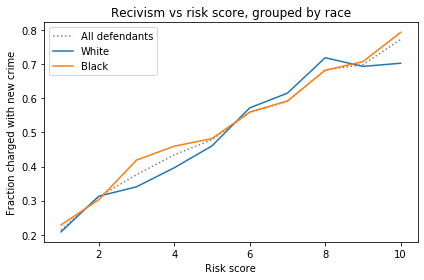

In [9]:
cal_all = calibration_curve(cp)
cal_all.plot(linestyle='dotted', 
              color='gray',
              label='All defendants')

cal_white = calibration_curve(cp[white])
cal_white.plot(label='White')

cal_white = calibration_curve(cp[black])
cal_white.plot(label='Black')

decorate(xlabel='Risk score',
         ylabel='Fraction charged with new crime',
         title='Recivism vs risk score, grouped by race')
plt.legend();

This figure shows that people with higher risk scores are more likely to be charged with a new crime within two years.  In that sense COMPAS works as intended; people with higher scores are more likely to recidivate.

Furthermore, the test is equally calibrated for black and white defendants; that is, in each risk group, the rate of recidivism is about the same for black and white defendants.

The WaPo article explains why this is important:

> A risk score of seven for black defendants should mean the same thing as a score of seven for white defendants. Imagine if that were not so, and we systematically assigned whites higher risk scores than equally risky black defendants with the goal of mitigating ProPublica’s criticism. We would consider that a violation of the fundamental tenet of equal treatment.

So we want a test that has the same calibration for all groups, and we want a test that has the same error rates for all groups.  

But there's the problem: as the WaPo article explains, it is mathematically impossible to be fair by both definitions at the same time.

To see why, let's go back to the confusion matrix.

## Matrices and metrics

As we saw in the previous notebook, here are the confusion matrices for white and black defendants.

In [10]:
matrix_white = make_matrix(cp[white])
matrix_white

Actual,Condition,No Condition
Predicted,,
Positive,505,349
Negative,461,1139


In [11]:
matrix_black = make_matrix(cp[black])
matrix_black

Actual,Condition,No Condition
Predicted,,
Positive,1369,805
Negative,532,990


And here are the metrics we computed from the confusion matrices:

In [12]:
metrics_white = compute_metrics(matrix_white, 
                                'White defendants')
metrics_white

,Percent
White defendants,
FPR,23.454301
FNR,47.722567
PPV,59.133489
NPV,71.187500
Prevalence,39.364303


In [13]:
metrics_black = compute_metrics(matrix_black, 
                                'Black defendants')
metrics_black

,Percent
Black defendants,
FPR,44.846797
FNR,27.985271
PPV,62.971481
NPV,65.045992
Prevalence,51.433983


If we look at the error rates (FPR and FNR), it seems like COMPAS is biased against black defendants:

* Their false positive rate is higher (45% vs 23%): among people who *will not* recidivate, black defendants are more likely to be classified high risk.

* Their false negative rate is lower (28% vs 48%): among people who *will* recidivate, black defendants are less likely to be classified low risk.

But if we look at the the predictive values (PPV and NPV) it seems like COMPAS is biased in favor of black defendants:

* Among people in the *high risk group*, black defendants are more likely to be charge with another crime (63% vs 59%).

* Among people in the *low risk group*, black defendants are less likely to "survive" two years without another charge (65% vs 71%).

It seems like we should be able to fix these problems, but it turns out that we can't. 

We'll see why in the next section

## What would it take?

Suppose we want to fix COMPAS so that predictive values are the same for black and white defendants.  We could do that by using different thresholds for the two groups.

In this section, we'll figure out what it would take to re-calibrate COMPAS; then we'll see what effect that would have on predictive values. 

The following function loops through possible thresholds, makes the confusion matrix with each threshold, and computes accuracy metrics.

In [14]:
def sweep_threshold(cp):
    """Sweep a range of threshold and compute accuracy metrics.
    
    cp: DataFrame of COMPAS data
    
    returns: DataFrame with one row for each threshold and
             one column for each metric
    """
    index = range(0, 11)
    columns = ['FPR', 'FNR', 'PPV', 'NPV', 'Prevalence']
    table = pd.DataFrame(index=index, columns=columns, dtype=float) 

    for threshold in index:
        m = make_matrix(cp, threshold)
        metrics = compute_metrics(m)
        table.loc[threshold] = metrics['Percent']
        
    return table

Here's the resulting table for all defendants.

In [15]:
table_all = sweep_threshold(cp)
table_all

,FPR,FNR,PPV,NPV,Prevalence
0,100.000000,0.000000,45.065151,NaN,45.065151
1,71.435781,9.474008,50.969865,78.611111,45.065151
2,55.084532,18.486620,54.831368,74.758505,45.065151
3,43.325763,27.130114,57.978463,71.803069,45.065151
4,32.349230,37.403876,61.350618,68.796510,45.065151
5,23.391370,47.431560,64.833080,66.317169,45.065151
6,16.250315,58.443556,67.719298,63.594558,45.065151
7,10.143830,69.209474,71.347113,61.280330,45.065151
8,6.056018,79.975392,73.063973,58.880278,45.065151
9,2.195307,90.895109,77.284595,56.741326,45.065151


The following figure shows error rates as a function of threshold.

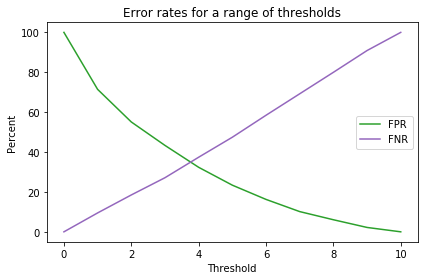

In [16]:
table_all['FPR'].plot(color='C2')
table_all['FNR'].plot(color='C4')

decorate(xlabel='Threshold', 
         ylabel='Percent',
         title='Error rates for a range of thresholds')
plt.legend();

When the threshold is low, almost everyone is in the high risk group; in that case:

* FNR is low because most recidivists are in the high risk group, but

* FPR is high because most non-recidivists are *also* in the high risk group. 

When the threshold is high, almost everyone is in the low risk group, and the metrics are the other way around:

* FPR is low because most non-recidivists are in the low risk group, but

* FNR is high because most recidivists are *also* in the low risk group.

The following figure shows predictive values for a range of thresholds.

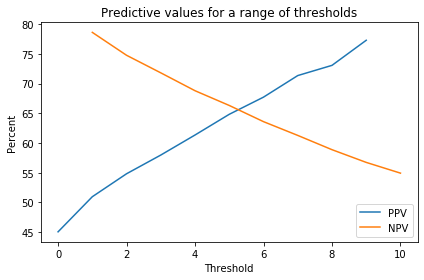

In [17]:
table_all['PPV'].plot(color='C0')
table_all['NPV'].plot(color='C1')

decorate(xlabel='Threshold', 
         ylabel='Percent',
         title='Predictive values for a range of thresholds')
plt.legend();

When the threshold is too low, PPV is low.  When the threshold is too high, NPV is low.

Now I'll compute tables for black and white defendants separately.

In [18]:
table_white = sweep_threshold(cp[white])

In [19]:
table_black = sweep_threshold(cp[black])

I'll use the following function to interpolate columns in the table; that is, for a given threshold I can compute the corresponding metric.

In [20]:
from scipy.interpolate import interp1d

def interpolate(series, value, **options):
    """Evaluate a function at a value.
    
    series: Series
    value: number
    options: passed to interp1d (default is linear interp)
    
    returns: number
    """
    interp = interp1d(series.index, series.values, **options)
    return interp(value)

The following function goes the other way: it estimates the threshold where a column passes through a given metric.

In [21]:
def crossing(series, value, **options):
    """Find where a function crosses a value.
    
    series: Series
    value: number
    options: passed to interp1d (default is linear interp)
    
    returns: number
    """
    interp = interp1d(series.values, series.index, **options)
    return interp(value)

We can use `crossing` to calibrate the test for white defendants; that is, we can compute the threshold that would make the error rates for white defendants the same as for the general population.

In [22]:
matrix_all = make_matrix(cp)
fpr, fnr = error_rates(matrix_all)

In [23]:
crossing(table_white['FPR'], fpr)

array(3.23048519)

In [24]:
crossing(table_white['FNR'], fnr)

array(3.11788885)

With a threshold near 3.2, white defendants would have the same error rates as the general population.

Now let's do the same computation for black defendants.

In [25]:
crossing(table_black['FPR'], fpr)

array(5.20906103)

In [26]:
crossing(table_black['FNR'], fnr)

array(5.01417524)

To get the same error rates for black and white defendants, we would need different thresholds: about 5.1 compared to 3.2.

At those levels, the predictive values are substantially different.  

Here's PPV for each group with different thresholds:

In [27]:
interpolate(table_white['PPV'], 3.2)

array(55.23319482)

In [28]:
interpolate(table_black['PPV'], 5.1)

array(66.21639173)

With equal error rates, we get different PPV:

* Among white defendants in the high risk group, about 55% would recidivate.

* Among black defendants in the high risk group, about 66% would recidivate.

Here's NPV for each group with different thresholds:

In [29]:
interpolate(table_white['NPV'], 3.2)

array(73.06639734)

In [30]:
interpolate(table_black['NPV'], 5.1)

array(62.16782561)

With equal error rates, the NPVs are substantially different:

* Among white defendants in the low risk group, 73% survive two years without another charge.

* Among black defendants in the low risk group, 62% survive.

To summarize, if the test is calibrated in terms of error rates, it is not calibrated in terms of predictive values.

* If we make the error rates more equal, we make the predictive values more unfair, and 

* If we make the predictive values more equal, we make the error rates more unfair.

Fundamentally, the problem is that the prevalence of recidivism is different in the two groups: about 39% of white defendants were charged with another crime within two years, compared to 51% of black defendants.

As long as that's the case (for any two groups) the predictive values and error rates can't be "fair" at the same time.

## ROC

In the previous section I plotted metrics as as function of threshold.  Another common and useful way to visualize these results is to plot sensitivity (which is the complement of FNR) versus FPR.  For historical reasons, the result is called a [receiver operating characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

The following function plots the ROC curve:

In [31]:
def plot_roc(table, **options):
    """Plot the ROC curve.
    
    table: DataFrame of metrics as a function of 
           classification threshold
    options: passed to plot
    """
    plt.plot([0,100], [0,100], ':', color='gray')
    sens = 100-table['FNR']
    plt.plot(table['FPR'], sens, **options)
    decorate(xlabel='FPR',
             ylabel='Sensitivity (1-FNR)',
             title='ROC curve')

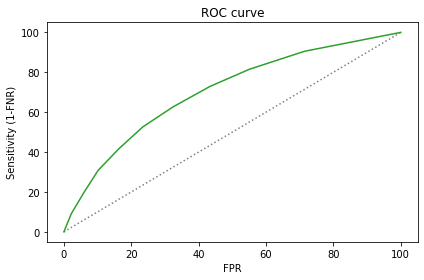

In [32]:
plot_roc(table_all, color='C2', label='All defendants')

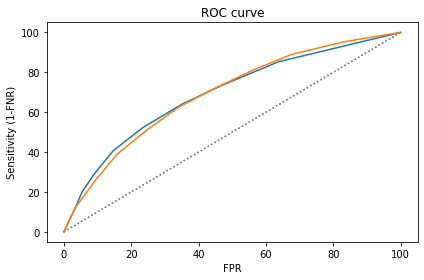

In [33]:
plot_roc(table_white)
plot_roc(table_black)

## AUC

The authors of the ProPublica article published a supplementary article,
[*How We Analyzed the COMPAS Recidivism Algorithm*](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm), which describes their analysis in more detail.

As another metric of accuracy, they estimate [concordance](https://cran.r-project.org/web/packages/survival/vignettes/concordance.pdf), which they describe like this:

> Overall, [COMPAS has] a concordance score of 63.6 percent.  That means for any randomly selected pair of defendants in the sample, the COMPAS system can accurately rank their recidivism risk 63.6 percent of the time (e.g. if one person of the pair recidivates, that pair will count as a successful match if that person also had a higher score). In its study, Northpointe reported a slightly higher concordance: 68 percent.

They explain: 

> [These estimates] are lower than what Northpointe describes as a threshold for reliability. “A rule of thumb according to several recent articles is that AUCs of .70 or above typically indicate satisfactory predictive accuracy, and measures between .60 and .70 suggest low to moderate predictive accuracy,” the company says in its study.

There are several ways to compute concordance, but one of the simplest is to compute the area under the ROC curve.  If you would like to know why, [you might find this discussion helpful](https://stats.stackexchange.com/questions/180638/how-to-derive-the-probabilistic-interpretation-of-the-auc).

Since we've already computed the ROC, we can use [Simpson's rule](https://en.wikipedia.org/wiki/Simpson%27s_rule) to estimate the area under the curve.

In [34]:
from scipy.integrate import simps

def compute_auc(table):
    """Compute the area under the ROC curve.
    
    Uses the trapezoid rule, so 
    """
    y = 100-table['FNR']
    x = table['FPR']
    y = y.sort_index(ascending=False) / 100
    x = x.sort_index(ascending=False) / 100
    return simps(y.values, x.values)

The concordance (AUC) for all respondents is about 70%.

In [35]:
compute_auc(table_all)

0.7059974460900778

For the subgroups it is slightly lower, but also near 70%.

In [36]:
compute_auc(table_white)

0.6995093159638619

In [37]:
compute_auc(table_black)

0.694567757058852

Different ways of computing concordance handle ties differently, which is probably why we, ProPublica, and Northpointe get somewhat different estimates.

But qualitatively they all tell the same story; as a binary classifier, COMPAS is only moderately accurate.  However, it seems to be equally accurate, by this metric, for white and black defendants.

## Summary

An ideal test should have equal predictive value in all groups; that is, two people with the same risk score should have the same probability of recidivism, regardless of what group they are in.

An ideal test should also have the same error rates for all groups; that is, two non-recidivists should have the same probability of being classified as high risk.

Unfortunately, these two goals are in conflict:

* If you design a test to achieve equal predictive value across groups with different prevalence, you will find that error rates depend on prevalence.  Specifically, false positive rates will be higher in groups with higher rates of recividism.

* If you design a test to achieve equal error rates across groups, you will find that predictive value depends on prevalence.  Specifically, positive predictive value will be lower in groups with lower rates of recidivism.

Our analysis so far suggests that COMPAS was designed to achieve some balance between predictive values and error rates.

In groups with high prevalence:

* FPR is lower than we would expect if the test had the same predictive value in all groups.

* As a result, PPV is lower than we would expect if error rates were the same in all groups.

In summary, this notebook explored two claims reported in the WaPo article:

* COMPAS is calibrated; that it, the risk scores it assigns correspond to the same probability of recidivism for black and white defendants.

* In groups with different prevalence, it is not possible to have the same predictive values and the same error rates.

We found that these claims are substantially correct; additionally, we found that COMPAS achieves some balance between predictive value and error rates, which may or may not be deliberate.

In [the next notebook]() I apply the same analysis to evaluate the performance of COMPAS for male and female defendants.  I find that COMPAS is unfair to women, but in a way that's opposite what we have seen so far: the error rates are about the same for both groups, but the predictive values are substantially different.